# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


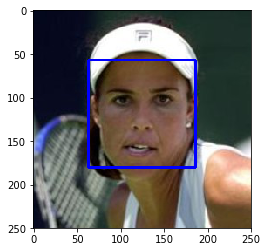

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[4])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

1. The percentage of recognized faces in the first 100 human images, is 98%
2. The percentage of human faces found in the first 100 dog images is 11%

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

num_detect_h_faces = 0

for h_face in human_files_short:
    if face_detector(h_face):
        num_detect_h_faces += 1
        
print("Found: ", num_detect_h_faces, " faces")

num_detect_dog_faces = 0
for h_face in dog_files_short:
    if face_detector(h_face):
        num_detect_dog_faces += 1
        
print("Found: ", num_detect_dog_faces, " faces in dog pictures")



Found:  98  faces
Found:  11  faces in dog pictures


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

There is not a perfect answer for this, but you could try to detect if the person wears clothes or if the person is standing up. Of course this approach would give some challenges if you put up a picture of a human catching tan on a beach wearing only swimming trunks. If we want to create a "human detector" instead of a "human face detector", then we would need to train on humans in many different kind of postures, both with and without faces. Also with different kind of clothes, shoes etc. These images would then have to be augmented to make the model more robust.
It is probably not an easy task, and it would require a lot of images.  

I think that requiring a human face to be detectable could be an acceptable limitation for now, until something better comes up.

---

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

# Alternative to OpenCV

I will use Dlib as face detector, since this is one I have used before with nice results. Dlib can be found here:
http://dlib.net

I found some good samples here, which I have been inspired by:
https://github.com/ageitgey/face_recognition

# Dlib example for facerecognition

I found 1 face(s) in this photograph.
A face is located at pixel location Top: 80, Left: 67, Bottom: 187, Right: 175


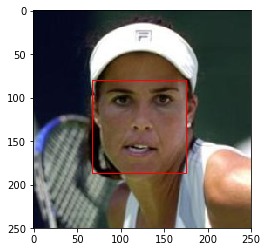

In [224]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

import face_recognition
import matplotlib.patches as patches
from PIL import Image, ImageDraw

def show_face(img, face_location):
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    draw_image = Image.fromarray(img)
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(draw_image)

    # Create a Rectangle patch
    rect = patches.Rectangle((left, top), (right - left), (bottom - top),linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()
    
# Load the jpg file into a numpy array
image = face_recognition.load_image_file(human_files_short[4])

# Find all the faces in the image using the default HOG-based model.
# This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
# See also: find_faces_in_picture_cnn.py
face_locations = face_recognition.face_locations(image)

print("I found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:
    show_face(image, face_location)


# Dlib implementation of human face detector

The performance of the Dlib detector is slightly better, especially on human faces.  
When a human face is found in the dog dataset then the image is presented, since I thought it was interesting to see where the model went wrong :-)  
It is interesting to see that the model will identify some pixels on the cheek of one of the dogs as a human face. It is not possible to see, with human eyes, why this is happening, but has probably something to do with the training of the model.  
The pixels in that area probably have values matching a human face, which could be why it is identified as such.

## Performance

Human : 100 faces in 100 pictures = 100% accuracy  
Dogs  : 10 faces wrongly found in 100 pictures = 90% accuracy


In [7]:
# returns "True" if face is detected in image stored at img_path
def dlib_face_detector(img_path):
    f_image = face_recognition.load_image_file(img_path)
    faces = face_recognition.face_locations(f_image)
        
    return len(faces) > 0, faces

In [8]:
num_detect_h_faces = 0

for h_face in human_files_short:
    if dlib_face_detector(h_face):
        num_detect_h_faces += 1
        
print("Found: ", num_detect_h_faces, " faces")



Found:  100  faces


A face is located at pixel location Top: 176, Left: 165, Bottom: 265, Right: 255


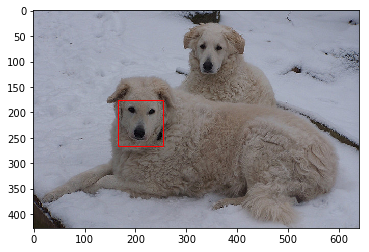

A face is located at pixel location Top: 211, Left: 53, Bottom: 340, Right: 182


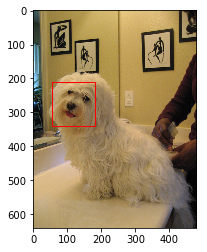

A face is located at pixel location Top: 179, Left: 237, Bottom: 254, Right: 312


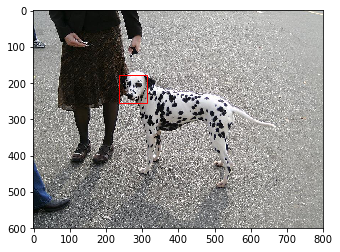

A face is located at pixel location Top: 77, Left: 139, Bottom: 263, Right: 324


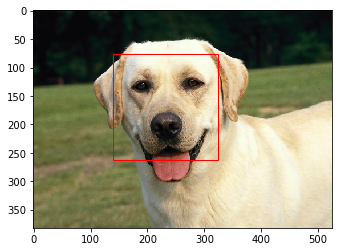

A face is located at pixel location Top: 137, Left: 237, Bottom: 180, Right: 280


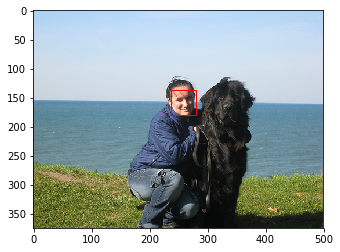

A face is located at pixel location Top: 95, Left: 95, Bottom: 147, Right: 147


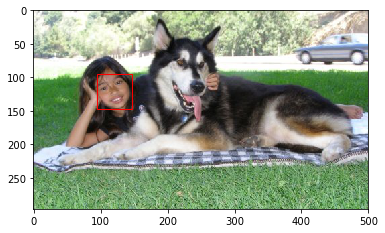

A face is located at pixel location Top: 102, Left: 189, Bottom: 138, Right: 225


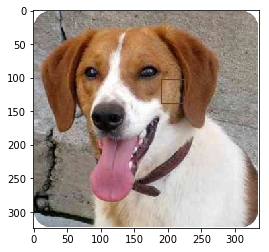

A face is located at pixel location Top: 67, Left: 311, Bottom: 196, Right: 440


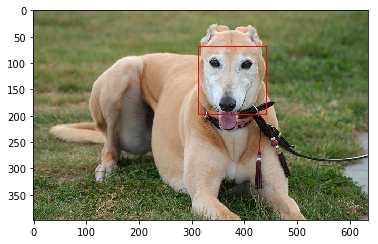

A face is located at pixel location Top: 80, Left: 115, Bottom: 187, Right: 223


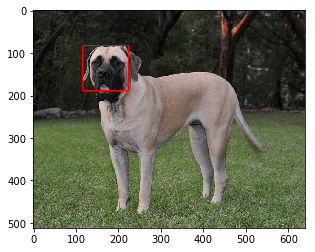

A face is located at pixel location Top: 77, Left: 304, Bottom: 263, Right: 489


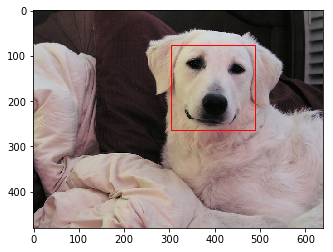

Found:  10  faces in dog pictures


In [9]:
num_detect_dog_faces = 0
counter = 0
for dog_face in dog_files_short:
    face_was_found, locations = dlib_face_detector(dog_face)
    if face_was_found:
        num_detect_dog_faces += 1
        dog_to_show = face_recognition.load_image_file(dog_face)
        for face_location in locations:
            show_face(dog_to_show, face_location)
    counter += 1
print("Found: ", num_detect_dog_faces, " faces in dog pictures")

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [227]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

## Performance for dog classifier

I have tested the performance for the dog classifier on the human_files_short and the dog_files_short datasets.  
The results was:

1. 99% precision for humans classifier
2. 100% precision for dog classifier

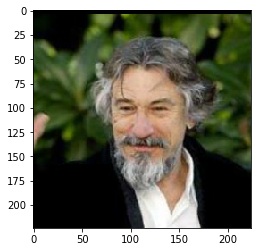

Found  1  dog candidate in human tensors


In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

num_dogs = 0
for human_img_path in human_files_short:
    if dog_detector(human_img_path):
        num_dogs += 1
        plt.imshow(image.load_img(human_img_path, target_size=(224, 224)))
        plt.show()

print('Found ', num_dogs, ' dog candidate in human tensors')

In [15]:
num_dogs = 0
for dog_img_path in dog_files_short:
    if dog_detector(dog_img_path):    
        num_dogs += 1
    else:
        print('Apparently this is not a dog!')
        plt.imshow(image.load_img(dog_img_path, target_size=(224, 224)))
        plt.show()

print('Found ', num_dogs, ' dogs in dog tensors')

Found  100  dogs in dog tensors


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:16<00:00, 51.75it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

## Answer

I have divided my answer into three steps, which illustrates the major experiences and decisions.

### Step 1
OK - so my first take was to try to get some baseline. This could be by implementing the sample network provided in this assignment. But since I want to expriment a bit, I decided to double the amount of filters to 128 and put in Dropouts between the layers to prevent overfitting. After long time of training it got me to 1.91% success rate. 
The architecture is shown below

```
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_47 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 128)       32896     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
global_average_pooling2d_15  (None, 128)               0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 133)               17157     
=================================================================
Total params: 60,597.0
Trainable params: 60,597.0
Non-trainable params: 0.0
_________________________________________________________________
```

It seemed OK, since the goal of this exercise was to achieve > 1%, but I wanted to try a couple of other architectures.

### Step 2
After that I tried to remove layers and instead of having many Conv2D layers, I introduced a Dense layer with 512 neurons after the convolutional layers with a dropout of 0.4. I thought this could be great to handle complexity in the features that was identified by the filters.  
Even though this also takes long time to train, the performance raised a bit. It reached 2.15%.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_33 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
global_average_pooling2d_11  (None, 32)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               16896     
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               68229     
=================================================================
Total params: 87,413.0
Trainable params: 87,413.0
Non-trainable params: 0.0
_________________________________________________________________

```

What if I combined the two approaches?

### Step 3

I tried to blend the two architectures, and the result improved a bit to 2.87%. Since this was the best result I got and it took me about 1/2 hour to train each model, I decided to stick with this architecure.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_35 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 128)       32896     
_________________________________________________________________
global_average_pooling2d_12  (None, 128)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_46 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 133)               68229     
=================================================================
Total params: 177,717.0
Trainable params: 177,717.0
Non-trainable params: 0.0
_________________________________________________________________

```

### Conclusion

The reason for why the architecture in step 3 is the best is probably because it is able to learn more advanced features due the number of filters in the last layer. Combined with the Dense layer at the end, it makes it able to separate the dog categories better, since it has more parameters. 
The result could probably improve by either continue the training for e.g. 20 epocs and see where that lead us, or try to create some more Dense layers. 512 neurons might not be the right fit here - perhaps 2 * 256 neurons would be better? There is a lot of options to try out.


In [98]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 56, 56, 64)        8256      
__________

### Compile the Model

In [99]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [93]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.step1.hdf5', 
                               verbose=1, save_best_only=True)



In [94]:
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 340s - loss: 4.8921 - acc: 0.0094 - val_loss: 4.8588 - val_acc: 0.0156
Epoch 2/5
6680/6680 [==============================] - 326s - loss: 4.8374 - acc: 0.0138 - val_loss: 4.8433 - val_acc: 0.0144
Epoch 3/5
6680/6680 [==============================] - 328s - loss: 4.8149 - acc: 0.0187 - val_loss: 4.8188 - val_acc: 0.0108
Epoch 4/5
6680/6680 [==============================] - 333s - loss: 4.8004 - acc: 0.0217 - val_loss: 4.7902 - val_acc: 0.0299
Epoch 5/5
6680/6680 [==============================] - 327s - loss: 4.7920 - acc: 0.0196 - val_loss: 4.8016 - val_acc: 0.0204


### Load the Model with the Best Validation Loss

In [100]:
model.load_weights('saved_models/weights.best.from_scratch.step3.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [101]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.8708%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [102]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [103]:
VGG16_dog_model = Sequential()
VGG16_dog_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_dog_model.add(Dense(133, activation='softmax'))

VGG16_dog_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_18  (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [104]:
VGG16_dog_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [105]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_dog_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s - loss: 11.7854 - acc: 0.1249 - val_loss: 9.4295 - val_acc: 0.2515
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 8.6328 - acc: 0.3319 - val_loss: 8.4164 - val_acc: 0.3545
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 7.8601 - acc: 0.4284 - val_loss: 8.0751 - val_acc: 0.4060
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 7.5670 - acc: 0.4692 - val_loss: 7.9751 - val_acc: 0.4144
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 7.3278 - acc: 0.4949 - val_loss: 7.8855 - val_acc: 0.4168
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 7.1923 - acc: 0.5154 - val_loss: 7.7659 - val_acc: 0.4395
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 7.1068 - acc: 0.5278 - val_loss: 7.8265 - val_acc: 0.4419
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 7.0251 - a

### Load the Model with the Best Validation Loss

In [106]:
VGG16_dog_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [107]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_dog_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.2057%


### Predict Dog Breed with the Model

In [108]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_dog_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [109]:
print(VGG16_predict_breed('siki.jpg'))


Golden_retriever


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [112]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import string

# Helper method to load bottleneck features from different network architectures
def load_bottleneck_features(network_name):
    str_name = 'bottleneck_features/Dog{network}Data.npz'
    file_name = str_name.replace('{network}', network_name)
    bottleneck_features = np.load(file_name)
    train_features = bottleneck_features['train']
    valid_features = bottleneck_features['valid']
    test_features = bottleneck_features['test']
    return train_features, valid_features, test_features
    

In [113]:
# Build the train, valid and test sets and name with names for each model they fit to

train_ResNet50, valid_ResNet50, test_ResNet50 = load_bottleneck_features('ResNet50')
train_VGG19, valid_VGG19, test_VGG19 = load_bottleneck_features('VGG19')
train_InceptionV3, valid_InceptionV3, test_InceptionV3 = load_bottleneck_features('InceptionV3')
train_Xception, valid_Xception, test_Xception = load_bottleneck_features('Xception')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I tried different types of architectures on top of each of the transfer learning networks. To be able to measure them against each other, I created a function to help in creating the same model for each network. 

The architecture I circled mostly around was how many layers I should add after the transfer values. It turned out that it was more beneficial to add layers to VGG19. The others, ResNet50, InceptionV3, Xception, did not change much and when they changed, it was for the worse. I am not sure why it is so, but I suspect that overfitting for  ResNet50, IncetpionV3 and Xception could be the cause. 

I quickly found out that I got the best result by adding a Dense layer with 128 neurons and add a Dropout layer with a fraction rate of 0.2. I also changed the optimizer to SGD instead of RMSprop. I just wanted to see the effect, and it appeared to be slightly better with SGD for this architecture.
Using ResNet50 i got it to about 83% and Xception to about 84%.

I have summarized the results with the current network architecture and the change of optimizers

| Network   |Architecure             |Optimizer|Result   |
|:----------|:-----------------------|:--------|--------:|
|Xception   |Dense 128, Dropout 0.2  |SGD      |84,92%   |
|ResNet50   |Dense 128, Dropout 0.2  |SGD      |83,25%   |
|Xception   |Dense 128, Dropout 0.2  |RmsProp  |82,89%   |
|InceptionV3|Dense 128, Dropout 0.2  |SGD      |82,77%   |
|ResNet50   |Dense 128, Dropout 0.2  |RmsProp  |80,14%   |
|InceptionV3|Dense 128, Dropout 0.2  |RmsProp  |80,02%   |
|VGG19      |Dense 128, Dropout 0.2  |SGD      |76,67%   |
|VGG19      |Dense 128, Dropout 0.2  |RmsProp  |72,36%   |

It can be seen that the highest accuracy is obtained using SGD on Xception and ResNet50. SGD performs best for all the networks trained here. This is probably because SGD is better at not getting stuck in a local minimum, for this problem.

Further experimentation could be to use other optimizers and change the learning rate. Also, it could be interesting to increase the number of epochs and introduce more layers, and then see what that can do in combination with the other hyperparameters. 

I believe the architecture is a sensible fit for this current problem, since it contains a balance between complexity and the time needed to train the network. 

In [138]:
### TODO: Define your architecture.

def build_model(train_shape):
    print('build shape', train_shape)
    build_model = Sequential()
    build_model.add(GlobalAveragePooling2D(input_shape=train_shape))
    build_model.add(Dense(128, activation='relu'))
    build_model.add(Dropout(0.2))
    build_model.add(Dense(133, activation='softmax'))
    build_model.summary()
    
    return build_model

In [147]:
print('Model for ResNet50')
ResNet50_dog_model = build_model(train_ResNet50.shape[1:])
print()

print('Model for VGG19')
VGG19_dog_model = build_model(train_VGG19.shape[1:])

print()
print('Model for InceptionV3')
InceptionV3_dog_model = build_model(train_InceptionV3.shape[1:])

print()
print('Model for Xception')
Xception_dog_model = build_model(train_Xception.shape[1:])

Model for ResNet50
build shape (1, 1, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_35  (None, 2048)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_86 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 133)               17157     
Total params: 279,429.0
Trainable params: 279,429.0
Non-trainable params: 0.0
_________________________________________________________________

Model for VGG19
build shape (7, 7, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_36  (None, 512)     

### (IMPLEMENTATION) Compile the Model

In [160]:
### TODO: Compile the model.
def compile_model(model_to_compile):
    #model_to_compile.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model_to_compile.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
compile_model(ResNet50_dog_model)
compile_model(VGG19_dog_model)
compile_model(InceptionV3_dog_model)
compile_model(Xception_dog_model)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [170]:
### TODO: Train the model.

def train_model(model_to_train, train_set, valid_set, model_name):
    model_file_name = 'saved_models/weights.best.{model_name}.hdf5'.replace('{model_name}', model_name)
    checkpointer_ = ModelCheckpoint(filepath=model_file_name, 
                               verbose=1, save_best_only=True)
    print('train.shape', train_set.shape)
    model_to_train.fit(train_set, train_targets, 
          validation_data=(valid_set, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_], verbose=1)
    

In [171]:
train_model(ResNet50_dog_model, train_ResNet50, valid_ResNet50, 'ResNet50')


train.shape (6680, 1, 1, 2048)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 0.0852 - acc: 0.9777 - val_loss: 0.5506 - val_acc: 0.8359
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.0791 - acc: 0.9793 - val_loss: 0.5582 - val_acc: 0.8359
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.0822 - acc: 0.9775 - val_loss: 0.5707 - val_acc: 0.8335
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.0779 - acc: 0.9772 - val_loss: 0.5564 - val_acc: 0.8323
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.0732 - acc: 0.9805 - val_loss: 0.5646 - val_acc: 0.8263
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.0742 - acc: 0.9807 - val_loss: 0.5522 - val_acc: 0.8335
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.0732 - acc: 0.9813 - val_loss: 0.5515 - val_acc: 0.8359
Epoch 8/20
6680/6680 [=========================

In [163]:
train_model(VGG19_dog_model, train_VGG19, valid_VGG19, 'VGG19')


train.shape (6680, 7, 7, 512)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s - loss: 0.5224 - acc: 0.8394 - val_loss: 0.9522 - val_acc: 0.7533
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.4673 - acc: 0.8540 - val_loss: 0.9559 - val_acc: 0.7437
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.4366 - acc: 0.8593 - val_loss: 0.9578 - val_acc: 0.7629
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.3870 - acc: 0.8751 - val_loss: 0.9285 - val_acc: 0.7557
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.3572 - acc: 0.8790 - val_loss: 0.9461 - val_acc: 0.7617
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.3453 - acc: 0.8877 - val_loss: 0.9628 - val_acc: 0.7617
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.3069 - acc: 0.8964 - val_loss: 0.9676 - val_acc: 0.7413
Epoch 8/20
6680/6680 [==========================

In [164]:
train_model(InceptionV3_dog_model, train_InceptionV3, valid_InceptionV3, 'InceptionV3')


train.shape (6680, 5, 5, 2048)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 11s - loss: 0.2122 - acc: 0.9310 - val_loss: 0.5285 - val_acc: 0.8647
Epoch 2/20
6680/6680 [==============================] - 3s - loss: 0.1826 - acc: 0.9353 - val_loss: 0.5196 - val_acc: 0.8587
Epoch 3/20
6680/6680 [==============================] - 3s - loss: 0.1677 - acc: 0.9440 - val_loss: 0.5258 - val_acc: 0.8527
Epoch 4/20
6680/6680 [==============================] - 3s - loss: 0.1522 - acc: 0.9479 - val_loss: 0.5259 - val_acc: 0.8551
Epoch 5/20
6680/6680 [==============================] - 3s - loss: 0.1449 - acc: 0.9518 - val_loss: 0.5254 - val_acc: 0.8623
Epoch 6/20
6680/6680 [==============================] - 3s - loss: 0.1361 - acc: 0.9543 - val_loss: 0.5348 - val_acc: 0.8623
Epoch 7/20
6680/6680 [==============================] - 3s - loss: 0.1345 - acc: 0.9542 - val_loss: 0.5265 - val_acc: 0.8563
Epoch 8/20
6680/6680 [========================

In [165]:
train_model(Xception_dog_model, train_Xception, valid_Xception, 'Xception')


train.shape (6680, 7, 7, 2048)
Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 12s - loss: 0.1974 - acc: 0.9346 - val_loss: 0.4659 - val_acc: 0.8455
Epoch 2/20
6680/6680 [==============================] - 5s - loss: 0.1668 - acc: 0.9449 - val_loss: 0.4585 - val_acc: 0.8515
Epoch 3/20
6680/6680 [==============================] - 5s - loss: 0.1560 - acc: 0.9488 - val_loss: 0.4617 - val_acc: 0.8491
Epoch 4/20
6680/6680 [==============================] - 6s - loss: 0.1547 - acc: 0.9490 - val_loss: 0.4614 - val_acc: 0.8539
Epoch 5/20
6680/6680 [==============================] - 5s - loss: 0.1461 - acc: 0.9506 - val_loss: 0.4624 - val_acc: 0.8563
Epoch 6/20
6680/6680 [==============================] - 5s - loss: 0.1375 - acc: 0.9587 - val_loss: 0.4599 - val_acc: 0.8575
Epoch 7/20
6680/6680 [==============================] - 5s - loss: 0.1369 - acc: 0.9582 - val_loss: 0.4559 - val_acc: 0.8515
Epoch 8/20
6680/6680 [========================

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [166]:
### TODO: Load the model weights with the best validation loss.

def load_model_weights(model, model_name):
    model_file_name = 'saved_models/weights.best.{model_name}.hdf5'.replace('{model_name}', model_name)
    model.load_weights(model_file_name)
    return model

In [167]:
ResNet50_loaded_dog_model = load_model_weights(ResNet50_dog_model, 'ResNet50')
VGG19_loaded_dog_model = load_model_weights(VGG19_dog_model, 'VGG19')
InceptionV3_loaded_dog_model = load_model_weights(InceptionV3_dog_model, 'InceptionV3')
Xception_loaded_dog_model = load_model_weights(Xception_dog_model, 'Xception')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [168]:
### TODO: Calculate classification accuracy on the test dataset.

def test_model(model_to_test, test_set):
    # get index of predicted dog breed for each image in test set
    model_predictions = [np.argmax(model_to_test.predict(np.expand_dims(feature, axis=0))) for feature in test_set]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)
    return float(test_accuracy)

In [169]:
print('Test accuracy for ResNet50: %.4f%%' % test_model(ResNet50_loaded_dog_model, test_ResNet50))
print('Test accuracy for VGG19: %.4f%%' % test_model(VGG19_loaded_dog_model, test_VGG19))
print('Test accuracy for InceptionV3: %.4f%%' % test_model(InceptionV3_loaded_dog_model, test_InceptionV3))
print('Test accuracy for Xception: %.4f%%' % test_model(Xception_loaded_dog_model, test_Xception))

Test accuracy for ResNet50: 83.2536%
Test accuracy for VGG19: 76.6746%
Test accuracy for InceptionV3: 82.7751%
Test accuracy for Xception: 84.9282%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [174]:

# I put the initialization of the transfer model up here, since it was pretty time consuming to initalize 
# the model on every call. 
from keras.applications.xception import Xception, preprocess_input
transfer_model = Xception(weights='imagenet', include_top=False)

In [179]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

import extract_bottleneck_features as bottleneck
import json

def extract_features(tensor):   
    return transfer_model.predict(preprocess_input(tensor))

def predict_dog_image(image_path):
    tensor = path_to_tensor(image_path)
    feature = extract_features(tensor)
    prediction_one_hot = Xception_dog_model.predict(feature)
    prediction = np.argmax(prediction_one_hot)
    
    return prediction


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [202]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input, decode_predictions

# define Xception model
Xception_model = Xception(weights='imagenet')

In [209]:
# Had to do a bit of work to make the image fit with Xception. The dimensions here are None, 299, 299, 3.
def path_to_xception_tensor(img_path):
    # convert PIL.Image.Image type to 3D tensor with shape (299, 299, 3)
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

### returns "True" if a dog is detected in the image stored at img_path
def is_dog(img_path):
    tensor = path_to_xception_tensor(img_path)
    img = xception_preprocess_input(tensor)
    prediction = Xception_model.predict(img)
    label_index = np.argmax(prediction)
    return ((label_index <= 268) & (label_index >= 151)) 
    
def is_human(img_path):
    return face_detector(img_path)

def predict_dog_breed(img_path):
    prediction = predict_dog_image(img_path)
    if is_dog(img_path):
        return dog_names[prediction]
    elif is_human(img_path) :
        return "Not a dog, but reminds of a " + dog_names[prediction]
    else:
        return "Not a dog, not a human, but it reminds of this kind of dog: " + dog_names[prediction]




---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

When presented with an image of a dog, it actually performs better than I expected. When presented with an image of a person (me, for instance) it gets quite funny!  

To begin with I used ResNet50 and that predicted me to be a "Chinese crested" dog. This a is rather ugly dog, so I was happy when I switched to Xception and it predicted me to be a "Newfoundland". This is much better :-)
I tried with other members of my family and the results are not very useful, but they are quite funny.

The algorithm performs quite well when it comes to identifying if an animal is not a dog, nor human. I tried with a rooster, a rabbit and a whale. The results are shown below.

### Improvement suggestions

I can think of some improvements to the algorithms:

1. It could be interesting to make the algorithm tell which animal it receives. Then it could just use the general Xception model to identify the animal - or perhaps a specific network trained to predict the different animal types
2. Predict the person that is identified as a human. Is it a woman, man, girl, boy? What age are we talking about? This would probably require a network specific trained on humans, since we deal with different kind of humans - chinese, africans, europeans etc. Also a model that predicts the age of a person could be interesting to use. This would probably require two different models trained on a large set of pictures of different human races with different ages etc.
3. Detect if the dog is a puppy or a grown up dog. Requires the model to be trained using labels for puppys and grown up dogs. Perhaps this would also require two models, one for the race and one for identifying if the dog is a puppy or grown up.
4. Given (1) and (2) is implemented, then if a picture of a child is sent in, then it could predict which puppy it reminds of the most
5. Instead of just returning the prediction, it could merge the features of the predicted dog breed with the received picture and return a new picture that showed how the human looked like the predicted dog





## Play with algorithm 


### Dog images

In [233]:
import matplotlib

def show_test_image(img_path):
    img = matplotlib.image.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

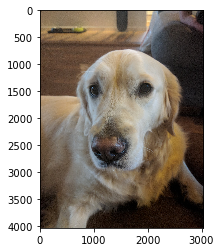

Golden_retriever


In [246]:
show_test_image('test_images/siki.jpg')
breed = predict_dog_breed('test_images/siki.jpg')
print(breed)

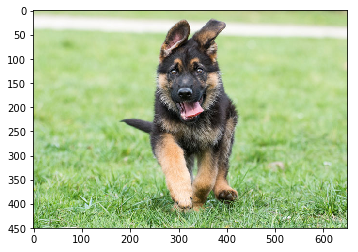

German_shepherd_dog


In [247]:
show_test_image('test_images/schaferpuppy.jpg')
breed = predict_dog_breed('test_images/schaferpuppy.jpg')
print(breed)

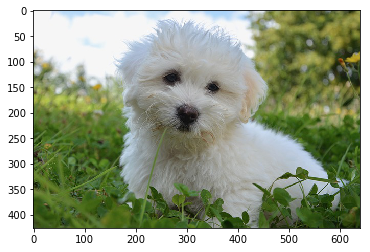

Bichon_frise


In [248]:
show_test_image('test_images/cotton_dog.jpg')
breed = predict_dog_breed('test_images/cotton_dog.jpg')
print(breed)

### Humans

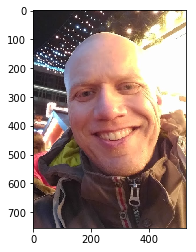

Not a dog, but reminds of a Newfoundland


In [249]:
show_test_image('test_images/soren.png')
breed = predict_dog_breed('test_images/soren.png')
print(breed)

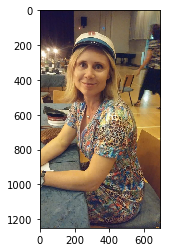

Not a dog, but reminds of a Poodle


In [250]:
show_test_image('test_images/pia.jpg')
breed = predict_dog_breed('test_images/pia.jpg')
print(breed)

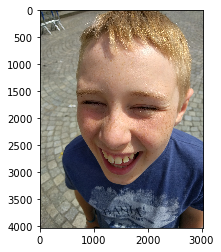

Not a dog, but reminds of a Glen_of_imaal_terrier


In [251]:
show_test_image('test_images/valdemar.jpg')
breed = predict_dog_breed('test_images/valdemar.jpg')
print(breed)

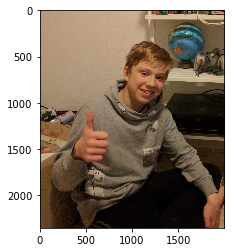

Not a dog, but reminds of a Dachshund


In [252]:
show_test_image('test_images/thorbjorn.png')
breed = predict_dog_breed('test_images/thorbjorn.png')
print(breed)

### Other animals

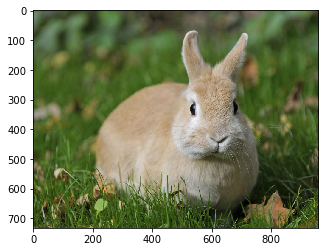

Not a dog, not a human, but it reminds of this kind of dog: Dachshund


In [253]:
show_test_image('test_images/rabbit.jpg')
breed = predict_dog_breed('test_images/rabbit.jpg')
print(breed)

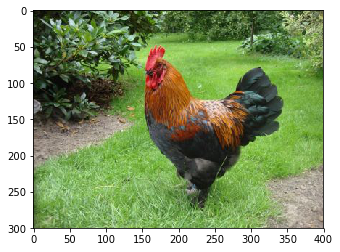

Not a dog, not a human, but it reminds of this kind of dog: Boykin_spaniel


In [254]:
show_test_image('test_images/hane.jpg')
breed = predict_dog_breed('test_images/hane.jpg')
print(breed)

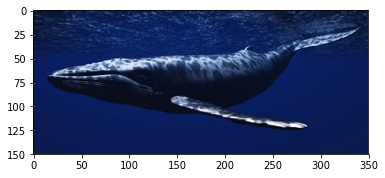

Not a dog, not a human, but it reminds of this kind of dog: Chinese_crested


In [255]:
show_test_image('test_images/bluewhale.jpg')
breed = predict_dog_breed('test_images/bluewhale.jpg')
print(breed)